# My first challenge for kaggle 
Task as part of the "Practical machine learning course" - dataworkshop.eu <br>
More information:
https://www.kaggle.com/c/diabetes-readmission/ <br>
my score: 1.37903 (rank 6) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
np.random.seed(2019)

from ml_metrics import rmsle
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier

import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from scikitplot.estimators import plot_learning_curve
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
import gc
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder


Using TensorFlow backend.


## Dane
To są prawdziwe dane.

**Uwaga!** Danych można używać tylko i wyłącznie w **celach edukacyjnych** (również nie można ich publikować lub dzielić się nimi z innymi)!

In [2]:
train = pd.read_hdf('../input/diabetic_train.h5')

In [3]:
test = pd.read_hdf('../input/diabetic_test.h5')
df_all = pd.concat([train, test])
del train, test
gc.collect()

159

Teraz już zastosuj swoją wiedzę, którą masz.
Spróbuj znaleźć lepsze cechy, lepszy model i lepsze parametry.

Powodzenia!

In [5]:
df_all.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id
33213,105238902,93379203,Caucasian,Female,[90-100),[50-75),1,4,7,6,...,0,0,0,0,0,0,False,True,0,33213
84750,267557436,81385569,Caucasian,Male,[70-80),?,1,1,7,1,...,0,0,0,0,0,0,False,True,100,84750
43319,133745040,113708169,Caucasian,Female,[70-80),?,1,2,7,1,...,1,0,0,0,0,0,False,True,0,43319
12880,51883632,18790479,Caucasian,Male,[60-70),?,1,1,7,3,...,1,0,0,0,0,0,False,True,,12880
100503,426688028,57602340,Caucasian,Female,[80-90),?,1,1,7,5,...,1,0,0,0,0,0,True,True,0,100503


## Dane

W celach optymalizacji szereg column (poniżej) zawierają wartości. Tu możesz zobaczyć słownik, który był użyty `{'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3}`
- `metformin`
- `repaglinide`
- `nateglinide`
- `chlorpropamide`
- `glimepiride`
- `acetohexamide`
- `glipizide`
- `glyburide`
- `tolbutamide`
- `pioglitazone`
- `rosiglitazone`
- `acarbose`
- `miglitol`
- `troglitazone`
- `tolazamide`
- `examide`
- `citoglipton`
- `insulin`
- `glyburide-metformin`
- `glipizide-metformin`
- `glimepiride-pioglitazone`
- `metformin-rosiglitazone`
- `metformin-pioglitazone`

Teraz czas na kodowanie...

In [6]:
cat_feats = df_all.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    df_all['{0}_cat'.format(cat_feat)] = pd.factorize( df_all[cat_feat] )[0]

In [7]:
def discharge_disposition_id_no_hosp(x):
    if x == 11: return 2
    if x == 13: return 2
    if x == 14: return 2
    if x == 19: return 2
    if x == 20: return 2
    if x == 21: return 2
    return 1
df_all['discharge_disposition_id_no_hosp'] = df_all['discharge_disposition_id'].map(lambda x: discharge_disposition_id_no_hosp(x)).astype(int)

In [8]:
top_doc = list(df_all['medical_specialty_cat'].value_counts().head(8).keys())

top_doc_norm = defaultdict(lambda: 100, dict(zip(top_doc, top_doc)))
df_all['top_doc'] = df_all['medical_specialty_cat'].map(top_doc_norm)
df_all['top_doc'].value_counts()

1      31733
9       9912
100     7668
2       4777
11      4559
3       3499
4       2053
5       1073
6        947
Name: top_doc, dtype: int64

In [9]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
         'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
         'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
         'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
         'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

In [10]:
def max_glu(row):
    if row['max_glu_serum'] == '>300': return 0
    return 1
df_all['max_glu'] = df_all[['max_glu_serum']].apply( max_glu, axis=1)

In [11]:
def age(row):
    if row['age_cat'] == 1 or row['age_cat'] == 8: return 1
    return 0
df_all['np_hospital_age'] = df_all[['age_cat']].apply( age, axis=1)

In [12]:
df_all['num_lab_procedures_cut']= pd.factorize( pd.cut(df_all['num_lab_procedures'], 5) )[0]

In [13]:
def diag_x(row):
    if row['diag_1'] == '428' or row['diag_1'] == '414': return 1
    if row['diag_2'] == '276' or row['diag_2'] == '428': return 1
    if row['diag_3'] == '250' or row['diag_3'] == '401': return 1
    return 0
df_all['diag_x'] = df_all[['diag_1', 'diag_2', 'diag_3']].apply(diag_x, axis=1)

In [14]:
pd.set_option('display.max_columns', 999)

In [15]:
df_all[df_all['readmitted']==100].sample(15)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id,race_cat,gender_cat,age_cat,weight_cat,payer_code_cat,medical_specialty_cat,diag_1_cat,diag_2_cat,diag_3_cat,max_glu_serum_cat,A1Cresult_cat,readmitted_cat,discharge_disposition_id_no_hosp,top_doc,max_glu,np_hospital_age,num_lab_procedures_cut,diag_x
20381,71878092,20711916,Caucasian,Female,[80-90),?,1,22,7,9,?,Family/GeneralPractice,48,0,8,0,0,1,428,414,V45,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,100,20381,0,0,4,0,0,2,6,17,21,0,0,1,1,2,1,0,0,1
81090,250821732,41450094,Caucasian,Male,[50-60),?,3,1,1,1,OG,?,10,6,12,0,0,0,414,413,794,8,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,100,81090,0,1,6,0,14,1,12,19,16,0,0,1,1,1,1,0,1,1
95390,361312886,42346944,?,Male,[60-70),?,1,3,7,7,MC,?,42,0,31,0,1,0,807,518,403,15,None,Norm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,100,95390,2,1,5,0,1,1,310,21,2,0,2,1,1,1,1,0,0,0
9003,39824436,5940954,AfricanAmerican,Female,[60-70),?,1,18,7,9,?,?,31,1,18,0,0,1,518,276,518,9,None,None,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,False,True,100,9003,1,0,5,0,0,1,96,37,100,0,0,1,1,1,1,0,0,1
29155,95350782,2940183,Caucasian,Female,[80-90),?,1,1,6,1,MC,InternalMedicine,39,0,8,0,0,0,457,272,250,4,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,100,29155,0,0,4,0,1,9,105,65,3,0,0,1,1,9,1,0,0,1
40701,126311478,23265909,AfricanAmerican,Male,[80-90),?,1,1,7,1,MC,InternalMedicine,44,1,12,0,0,0,276,403,250.6,9,None,None,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,100,40701,1,1,4,0,1,9,75,25,6,0,0,1,1,9,1,0,0,0
24917,83875608,100423566,Caucasian,Male,[70-80),?,1,1,7,7,?,Family/GeneralPractice,48,0,15,1,0,0,466,428,425,8,None,None,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,100,24917,0,1,7,0,0,2,60,9,29,0,0,1,1,2,1,0,0,1
96534,376679210,42535755,Caucasian,Male,[70-80),?,1,6,7,1,MC,?,44,0,11,1,3,1,428,401,412,6,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,100,96534,0,1,7,0,1,1,6,7,86,0,0,1,1,1,1,0,0,1
92828,327757244,100140957,Caucasian,Male,[70-80),[175-200),1,6,7,10,MC,?,76,1,22,3,0,0,250.8,730,731,9,None,>8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,True,100,92828,0,1,7,8,1,1,35,158,142,0,3,1,1,1,1,0,2,0
3268,20405868,23844609,Caucasian,Male,[40-50),?,5,5,17,1,?,?,27,0,5,0,2,0,966,E950,E950,8,>200,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,100,3268,0,1,3,0,0,1,190,185,200,3,0,1,1,1,1,0,1,0


In [16]:
top_race = list(df_all['race_cat'].value_counts().head(2).keys())

title_race = defaultdict(lambda: 10, dict(zip(top_race, top_race)))
df_all['top_race'] = df_all['race_cat'].map(title_race)
df_all['top_race'].value_counts()

0     48975
1     12576
10     4670
Name: top_race, dtype: int64

In [17]:
df_all['max_glu'].value_counts()

1    65478
0      743
Name: max_glu, dtype: int64

In [18]:
def discharge_disposition_age(row):
    if row['discharge_disposition_id'] == 2 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 3 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 9 and row['age_cat'] == 5: return 1
    if row['discharge_disposition_id'] == 12 and row['age_cat'] == 7: return 1
    if row['discharge_disposition_id'] == 15 and row['age_cat'] == 4: return 1
    if row['discharge_disposition_id'] == 15 and row['age_cat'] == 6: return 1
    if row['discharge_disposition_id'] == 15 and row['age_cat'] == 7: return 1
    if row['discharge_disposition_id'] == 15 and row['age_cat'] == 9: return 1
    if row['discharge_disposition_id'] == 22 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 22 and row['age_cat'] == 8: return 1
    if row['discharge_disposition_id'] == 28 and row['age_cat'] == 4: return 1
    return 0

df_all['discharge_disposition_age'] = df_all[['discharge_disposition_id', 'age_cat']].apply(discharge_disposition_age, axis=1)

In [19]:
def discharge_disposition_age_no_hos(row):
    if row['discharge_disposition_id'] == 1 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 2 and row['age_cat'] == 0: return 1
    if row['discharge_disposition_id'] == 2 and row['age_cat'] == 8: return 1
    if row['discharge_disposition_id'] == 3 and row['age_cat'] == 8: return 1
    if row['discharge_disposition_id'] == 3 and row['age_cat'] == 0: return 1
    if row['discharge_disposition_id'] == 4 and row['age_cat'] == 0: return 1
    if row['discharge_disposition_id'] == 4 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 4 and row['age_cat'] == 2: return 1
    if row['discharge_disposition_id'] == 4 and row['age_cat'] == 8: return 1
    if row['discharge_disposition_id'] == 5 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 5 and row['age_cat'] == 8: return 1
    if row['discharge_disposition_id'] == 6 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 6 and row['age_cat'] == 8: return 1
    if row['discharge_disposition_id'] == 7 and row['age_cat'] == 0: return 1
    if row['discharge_disposition_id'] == 7 and row['age_cat'] == 8: return 1
    if row['discharge_disposition_id'] == 7 and row['age_cat'] == 9: return 1
    if row['discharge_disposition_id'] == 8 and row['age_cat'] != 5: return 1
    if row['discharge_disposition_id'] == 8 and row['age_cat'] != 6: return 1
    if row['discharge_disposition_id'] == 8 and row['age_cat'] != 7: return 1
    if row['discharge_disposition_id'] == 9 and row['age_cat'] != 3: return 1
    if row['discharge_disposition_id'] == 9 and row['age_cat'] != 5: return 1
    if row['discharge_disposition_id'] == 9 and row['age_cat'] != 7: return 1
    if row['discharge_disposition_id'] == 10: return 1
    if row['discharge_disposition_id'] == 11: return 1
    if row['discharge_disposition_id'] == 12 and row['age_cat'] != 7: return 1
    if row['discharge_disposition_id'] == 13 and row['age_cat'] == 0: return 1
    if row['discharge_disposition_id'] == 13 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 13 and row['age_cat'] == 2: return 1
    if row['discharge_disposition_id'] == 13 and row['age_cat'] == 8: return 1
    if row['discharge_disposition_id'] == 14 and row['age_cat'] != 3: return 1
    if row['discharge_disposition_id'] == 14 and row['age_cat'] != 4: return 1
    if row['discharge_disposition_id'] == 14 and row['age_cat'] != 5: return 1
    if row['discharge_disposition_id'] == 14 and row['age_cat'] != 8: return 1
    if row['discharge_disposition_id'] == 15 and row['age_cat'] != 3: return 1
    if row['discharge_disposition_id'] == 15 and row['age_cat'] != 4: return 1
    if row['discharge_disposition_id'] == 15 and row['age_cat'] != 6: return 1
    if row['discharge_disposition_id'] == 15 and row['age_cat'] != 7: return 1
    if row['discharge_disposition_id'] == 15 and row['age_cat'] != 9: return 1
    if row['discharge_disposition_id'] == 16: return 1
    if row['discharge_disposition_id'] == 17: return 1
    if row['discharge_disposition_id'] == 18 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 18 and row['age_cat'] == 8: return 1
    if row['discharge_disposition_id'] == 19: return 1
    if row['discharge_disposition_id'] == 20: return 1
    if row['discharge_disposition_id'] == 22 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 23 and row['age_cat'] != 4: return 1
    if row['discharge_disposition_id'] == 23 and row['age_cat'] != 5: return 1
    if row['discharge_disposition_id'] == 23 and row['age_cat'] != 6: return 1
    if row['discharge_disposition_id'] == 23 and row['age_cat'] != 7: return 1
    if row['discharge_disposition_id'] == 23 and row['age_cat'] != 9: return 1
    if row['discharge_disposition_id'] == 24 and row['age_cat'] != 4: return 1
    if row['discharge_disposition_id'] == 24 and row['age_cat'] != 5: return 1
    if row['discharge_disposition_id'] == 25 and row['age_cat'] == 0: return 1
    if row['discharge_disposition_id'] == 25 and row['age_cat'] == 9: return 1
    if row['discharge_disposition_id'] == 27: return 1
    if row['discharge_disposition_id'] == 28 and row['age_cat'] == 0: return 1
    if row['discharge_disposition_id'] == 28 and row['age_cat'] == 1: return 1
    if row['discharge_disposition_id'] == 28 and row['age_cat'] == 2: return 1
    if row['discharge_disposition_id'] == 28 and row['age_cat'] == 8: return 1
    return 0

df_all['discharge_disposition_age_no_hos'] = df_all[['discharge_disposition_id', 'age_cat']].apply(discharge_disposition_age_no_hos, axis=1)

In [20]:
df_all['discharge_disposition_age_no_hos'].value_counts()

0    62599
1     3622
Name: discharge_disposition_age_no_hos, dtype: int64

In [21]:
df_all['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [22]:
def weight_age(row):
    if row['weight_cat'] == 4 and row['age_cat'] == 0: return 1
    if row['weight_cat'] == 5 and row['age_cat'] == 2: return 1
    if row['weight_cat'] == 8 and row['age_cat'] == 7: return 1
    return 0
df_all['weight_age'] = df_all[['weight_cat','age_cat']].apply( weight_age, axis=1)

In [23]:
def weight_age_no_hos(row):
    if row['weight_cat'] == 0 and row['age_cat'] == 0: return 1
    if row['weight_cat'] == 1 and row['age_cat'] == 0: return 1
    if row['weight_cat'] == 1 and row['age_cat'] == 7: return 1
    if row['weight_cat'] == 1 and row['age_cat'] == 0: return 1
    if row['weight_cat'] == 2 and row['age_cat'] == 8: return 1
    if row['weight_cat'] == 3 and (row['age_cat'] != 3 or row['age_cat'] != 5 or row['age_cat'] != 7): return 1
    if row['weight_cat'] == 4 and (row['age_cat'] != 0 or row['age_cat'] != 5 or row['age_cat'] != 7): return 1
    if row['weight_cat'] == 5 and (row['age_cat'] != 2 or row['age_cat'] != 4 or row['age_cat'] != 6): return 1
    if row['weight_cat'] == 6 and row['age_cat'] == 0: return 1
    if row['weight_cat'] == 6 and row['age_cat'] == 2: return 1
    if row['weight_cat'] == 6 and row['age_cat'] == 8: return 1
    if row['weight_cat'] == 6 and row['age_cat'] == 9: return 1
    if row['weight_cat'] == 7 and row['age_cat'] != 5: return 1
    if row['weight_cat'] == 8 and row['age_cat'] != 7: return 1
    
    return 0
df_all['weight_age_no_hos'] = df_all[['weight_cat','age_cat']].apply( weight_age_no_hos, axis=1)

In [24]:
def number_emergency_gender(row):
    if row['number_emergency'] == 7 and row['gender_cat'] == 1: return 1
    if row['number_emergency'] == 8 and row['gender_cat'] == 1: return 1
    if row['number_emergency'] == 9 and row['gender_cat'] == 0: return 1
    if row['number_emergency'] == 9 and row['gender_cat'] == 1: return 1
    if row['number_emergency'] == 10 and row['gender_cat'] == 1: return 1
    if row['number_emergency'] == 11 and row['gender_cat'] == 0: return 1
    if row['number_emergency'] == 12 and row['gender_cat'] == 0: return 1
    if row['number_emergency'] == 12 and row['gender_cat'] == 1: return 1
    if row['number_emergency'] == 13 and row['gender_cat'] == 1: return 1
    if row['number_emergency'] == 19 and row['gender_cat'] == 0: return 1
    if row['number_emergency'] == 20 and row['gender_cat'] == 0: return 1
    if row['number_emergency'] == 28 and row['gender_cat'] == 1: return 1
    if row['number_emergency'] == 64 and row['gender_cat'] == 0: return 1
 
    return 0
df_all['number_emergency_gender'] =df_all[['number_emergency','gender_cat']].apply(number_emergency_gender, axis=1)

In [25]:
plot = df_all[ df_all.readmitted_cat != 2 ]

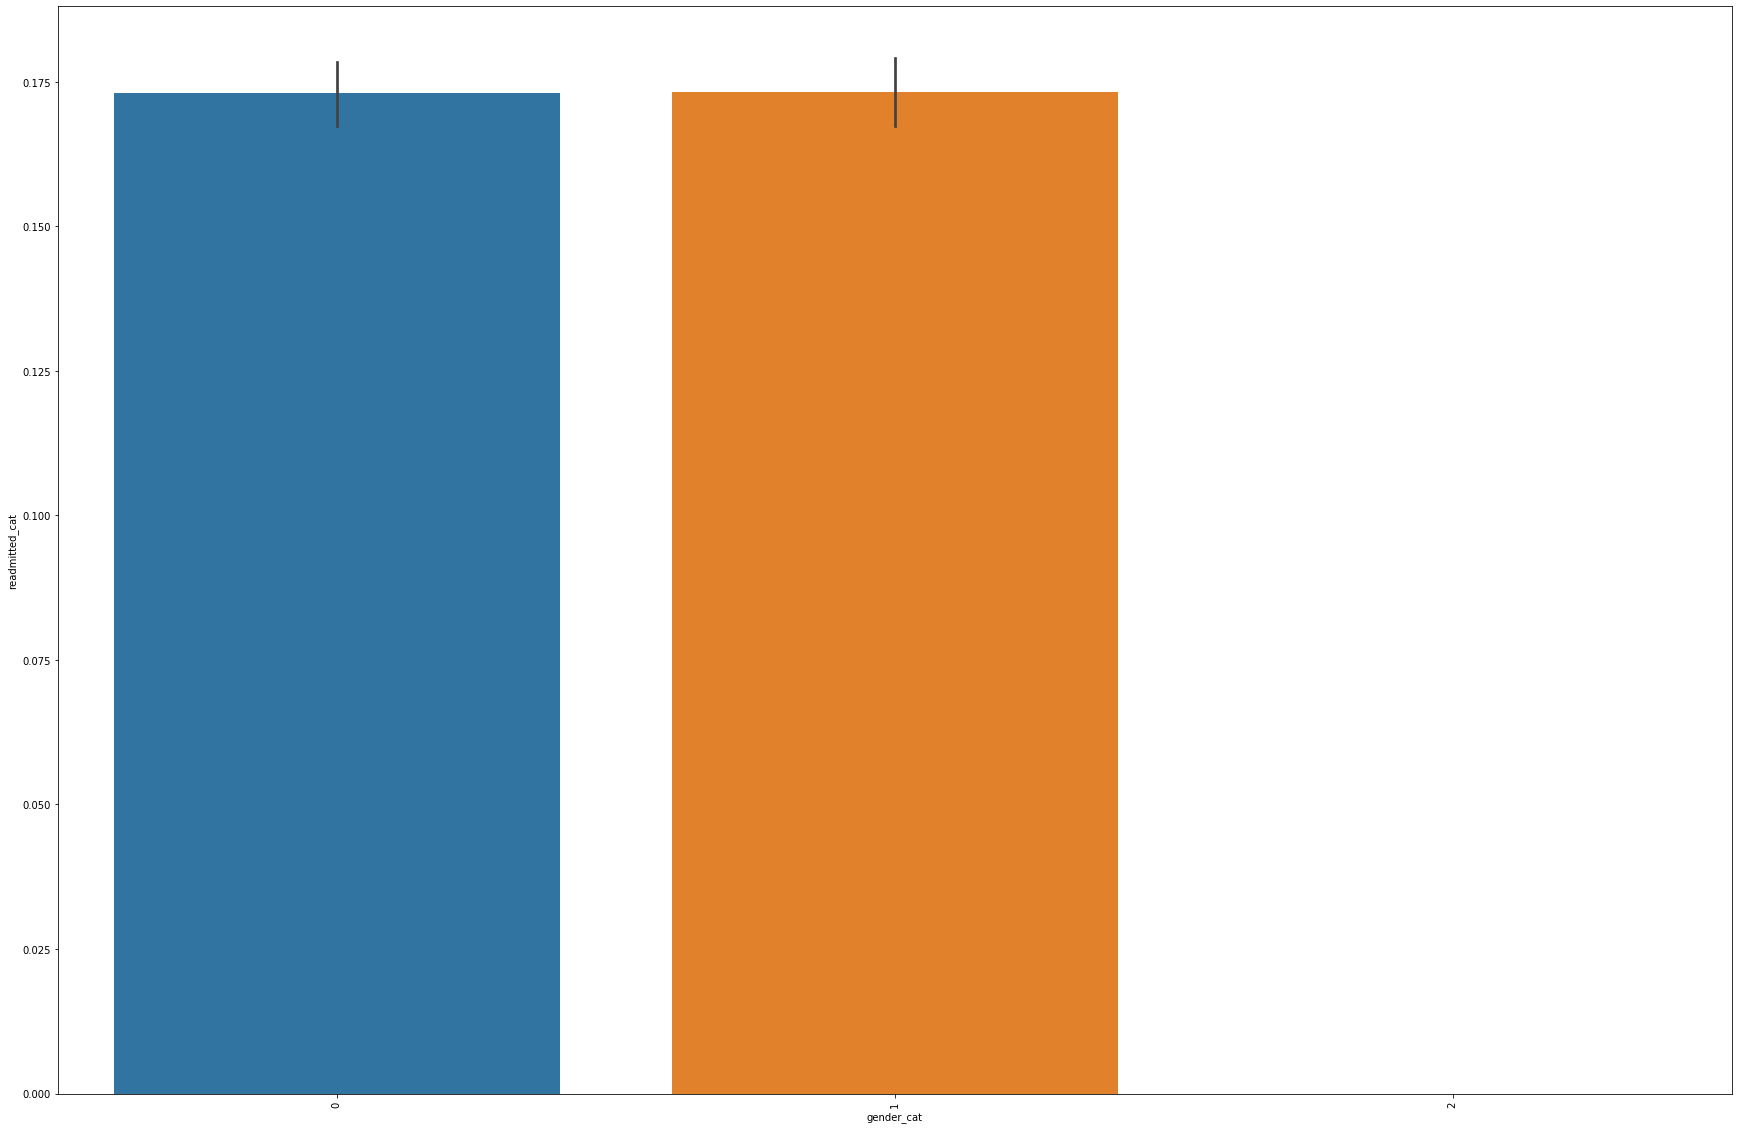

In [26]:
plt.figure(figsize=(30, 20))
sns.barplot(x='gender_cat', y='readmitted_cat', data=plot)
plt.xticks(rotation=90);

In [27]:
def weight_age(row):
    if row['weight_cat'] == 5 and row['race_cat'] == 2: return 1
    if row['weight_cat'] == 5 and row['race_cat'] == 4: return 1
    if row['weight_cat'] == 6 and row['race_cat'] != 0: return 1
    if row['weight_cat'] == 6 and row['race_cat'] != 1: return 1
    return 0
df_all['weight_age'] = df_all[['weight_cat','race_cat']].apply( weight_age, axis=1)

In [28]:
plot.pivot_table(values=['readmitted_cat'], index=['gender_cat'])

,readmitted_cat
gender_cat,
0,0.173016
1,0.173221
2,0.000000


In [29]:
def diagnoses_age(row):
    if row['number_diagnoses'] == 1 and row['age_cat'] != 0: return 1
    if row['number_diagnoses'] == 1 and row['age_cat'] != 1: return 1
    if row['number_diagnoses'] == 1 and row['age_cat'] != 2: return 1
    if row['number_diagnoses'] == 1 and row['age_cat'] != 8: return 1
    if row['number_diagnoses'] == 10 and row['age_cat'] != 4: return 1
    if row['number_diagnoses'] == 11 and row['age_cat'] != 5: return 1
    if row['number_diagnoses'] == 11 and row['age_cat'] != 7: return 1
    if row['number_diagnoses'] == 12: return 1
    if row['number_diagnoses'] == 13 and row['age_cat'] != 5: return 1
    if row['number_diagnoses'] == 14: return 1
    if row['number_diagnoses'] == 15 and row['age_cat'] != 5: return 1
    if row['number_diagnoses'] == 16 and row['age_cat'] != 5: return 1
    return 0
df_all['diagnoses_age'] = df_all[['number_diagnoses', 'age_cat']].apply(diagnoses_age, axis=1)

In [30]:
df_all['diagnoses_age'].value_counts()

0    65989
1      232
Name: diagnoses_age, dtype: int64

In [31]:
def nr_emergency_race(row):
    if row["race_cat"] == 0 and row["number_emergency"] == 9 : return 1
    if row["race_cat"] == 0 and row["number_emergency"] == 10 : return 1
    if row["race_cat"] == 0 and row["number_emergency"] == 11 : return 1
    if row["race_cat"] == 0 and row["number_emergency"] == 13 : return 1
    if row["race_cat"] == 0 and row["number_emergency"] == 19 : return 1
    if row["race_cat"] == 0 and row["number_emergency"] == 20: return 1
    if row["race_cat"] == 0 and row["number_emergency"] == 28 : return 1
    if row["race_cat"] == 0 and row["number_emergency"] == 64 : return 1
    if row["race_cat"] == 1 and row["number_emergency"] == 7 : return 1
    if row["race_cat"] == 1 and row["number_emergency"] == 9 : return 1
    if row["race_cat"] == 1 and row["number_emergency"] == 12 : return 1
    if row["race_cat"] == 3 and row["number_emergency"] == 8 : return 1
    if row["race_cat"] == 3 and row["number_emergency"] == 12 : return 1
    if row["race_cat"] == 5 and row["number_emergency"] == 4 : return 1
    if row["race_cat"] == 5 and row["number_emergency"] == 7 : return 1
    if row["race_cat"] == 5 and row["number_emergency"] == 9 : return 1
    return 0
df_all['nr_emergency_race'] = df_all[["race_cat","number_emergency"]].apply(nr_emergency_race, axis=1)

In [32]:
def drug_up(row):
    for i in drugs:
        if row[i] == 2: return 1
        return 0
df_all['drug_up'] = df_all[drugs].apply( drug_up, axis=1)

In [33]:
def drug_down_st(row):
    for i in drugs:
        if row[i] == 3 or row[i] == 1: return 1
        return 0
df_all['drug_down_st'] = df_all[drugs].apply( drug_down_st, axis=1)

In [34]:
df_all['drug_down_st'].value_counts()

0    53659
1    12562
Name: drug_down_st, dtype: int64

In [35]:
def admision_age(row):
    if row['admission_type_id'] != 6 and row['age_cat'] == 0 : return 1
    if row['admission_type_id'] == 4 and row['age_cat'] != 5: return 1
    if row['admission_type_id'] == 5 and row['age_cat'] == 8 : return 1
    if row['admission_type_id'] == 7: return 1
    if row['admission_type_id'] == 8 and (row['age_cat'] != 4 or row['age_cat'] != 5 or row['age_cat'] != 6): return 1
    if row['admission_type_id'] == 9 and row['age_cat'] == 9 : return 1
    return 0
df_all['admision_age'] = df_all[['admission_type_id', 'age_cat']].apply( admision_age, axis=1)

In [36]:
df_all['admision_age'].value_counts()

0    65831
1      390
Name: admision_age, dtype: int64

In [37]:
df_all['visit_patient'] = df_all.groupby('patient_nbr')['patient_nbr'].transform('count')

In [38]:
df_all['medical_specialty_popular'] = df_all.groupby('medical_specialty')['medical_specialty'].transform('count')

In [39]:
def visit_payer_cat(row):
    if row['visit_patient'] == 2 and row['payer_code_cat'] == 14: return 1
    if row['visit_patient'] == 3 and row['payer_code_cat'] == 9: return 1
    if row['visit_patient'] == 3 and row['payer_code_cat'] == 11: return 1
    if row['visit_patient'] == 3 and row['payer_code_cat'] == 13: return 1
    if row['visit_patient'] == 3 and row['payer_code_cat'] == 15: return 1
    if row['visit_patient'] == 4 and row['payer_code_cat'] == 7: return 1
    if row['visit_patient'] == 4 and row['payer_code_cat'] == 9: return 1
    if row['visit_patient'] == 4 and row['payer_code_cat'] == 10: return 1
    if row['visit_patient'] == 4 and row['payer_code_cat'] == 17: return 1
    if row['visit_patient'] == 5 and row['payer_code_cat'] == 3: return 1
    if row['visit_patient'] == 5 and row['payer_code_cat'] == 5: return 1
    if row['visit_patient'] == 5 and row['payer_code_cat'] == 8: return 1
    if row['visit_patient'] == 5 and row['payer_code_cat'] == 14: return 1
    if row['visit_patient'] == 6 and row['payer_code_cat'] == 2: return 1
    if row['visit_patient'] == 6 and row['payer_code_cat'] == 6: return 1
    if row['visit_patient'] == 6 and row['payer_code_cat'] == 8: return 1
    if row['visit_patient'] == 6 and row['payer_code_cat'] == 9: return 1
    if row['visit_patient'] == 6 and row['payer_code_cat'] == 14: return 1
    if row['visit_patient'] == 7 and row['payer_code_cat'] == 2: return 1
    if row['visit_patient'] == 7 and row['payer_code_cat'] == 4: return 1
    if row['visit_patient'] == 7 and row['payer_code_cat'] == 7: return 1
    if row['visit_patient'] == 7 and row['payer_code_cat'] == 9: return 1
    if row['visit_patient'] == 8 and row['payer_code_cat'] == 0: return 1
    if row['visit_patient'] == 8 and row['payer_code_cat'] == 1: return 1
    if row['visit_patient'] == 8 and row['payer_code_cat'] == 2: return 1
    if row['visit_patient'] == 8 and row['payer_code_cat'] == 3: return 1
    if row['visit_patient'] == 8 and row['payer_code_cat'] == 4: return 1
    if row['visit_patient'] == 8 and row['payer_code_cat'] == 9: return 1
    if row['visit_patient'] == 9 and row['payer_code_cat'] == 2: return 1
    if row['visit_patient'] == 9 and row['payer_code_cat'] == 5: return 1
    if row['visit_patient'] == 9 and row['payer_code_cat'] == 6: return 1
    if row['visit_patient'] == 9 and row['payer_code_cat'] == 9: return 1
    if row['visit_patient'] == 10 and row['payer_code_cat'] == 0: return 1
    if row['visit_patient'] == 10 and row['payer_code_cat'] == 1: return 1
    if row['visit_patient'] == 11 and row['payer_code_cat'] == 0: return 1
    if row['visit_patient'] == 12 and row['payer_code_cat'] == 4: return 1
    if row['visit_patient'] == 12 and row['payer_code_cat'] == 5: return 1
    if row['visit_patient'] == 12 and row['payer_code_cat'] == 8: return 1
    if row['visit_patient'] == 12 and row['payer_code_cat'] == 9: return 1
    if row['visit_patient'] == 13 and row['payer_code_cat'] == 0: return 1
    if row['visit_patient'] == 13 and row['payer_code_cat'] == 1: return 1
    if row['visit_patient'] == 13 and row['payer_code_cat'] == 4: return 1
    if row['visit_patient'] == 13 and row['payer_code_cat'] == 5: return 1
    if row['visit_patient'] == 13 and row['payer_code_cat'] == 9: return 1
    if row['visit_patient'] == 4 and row['payer_code_cat'] == 2: return 1
    if row['visit_patient'] == 4 and row['payer_code_cat'] == 5: return 1
    if row['visit_patient'] == 4 and row['payer_code_cat'] == 9: return 1
    if row['visit_patient'] == 4 and row['payer_code_cat'] == 14: return 1
    return 0
df_all['visit_payer_cat'] = df_all[['visit_patient','payer_code_cat']].apply( visit_payer_cat, axis=1)

In [40]:
df_all['visit_payer_cat'].value_counts()

0    65760
1      461
Name: visit_payer_cat, dtype: int64

In [41]:
def A1Cresult_max_glu_serum(row):
    if row['A1Cresult'] == "Norm" and row['max_glu_serum'] == '>200': return 1
    if row['A1Cresult'] == ">7" and row['max_glu_serum'] == '>300': return 1
    return 0
df_all['A1Cresult_max_glu_serum'] = df_all[['A1Cresult', 'max_glu_serum']].apply( A1Cresult_max_glu_serum, axis=1)

In [42]:
def number_outpatient_risk(row):
    if row['number_outpatient'] == 22 or row['number_outpatient'] == 23: return 1
    return 0
df_all['number_outpatient_risk'] = df_all[['number_outpatient']].apply( number_outpatient_risk, axis=1)

In [43]:
def drug_hospital(row):
    if row['repaglinide'] == 3: return 1
    if row['nateglinide'] == 2 or row['nateglinide'] == 3: return 1
    if row['chlorpropamide'] == 2: return 1
    if row['miglitol'] == 1: return 1
    if row['troglitazone'] == 1: return 1
    if row['glyburide-metformin'] == 2 or row['glyburide-metformin'] == 3: return 1
    return 0
df_all['drug_hospital'] = df_all[['repaglinide', 'nateglinide','chlorpropamide', 'miglitol',
                               'troglitazone', 'glyburide-metformin']].apply(drug_hospital, axis=1)

In [44]:
df_all['visit_patient'] = df_all.groupby('patient_nbr')['patient_nbr'].transform('count')

In [45]:
def admission_source_idx(row):
    if row['admission_source_id'] == 7: return 1
    if row['admission_source_id'] == 1: return 1
    if row['admission_source_id'] == 8: return 1
    if row['admission_source_id'] == 20: return 1
    return 0
df_all['admission_source_idx'] = df_all[['admission_source_id']].apply(admission_source_idx, axis=1)

In [46]:
def gender_weight(row):
    if row['gender'] == "Male" and row['weight_cat'] == 8 or row['weight_cat'] == 4: return 1
    return 0
df_all['gender_weight'] = df_all[['gender', 'weight_cat']].apply( gender_weight, axis=1)

In [47]:
df_all['gender_weight'].value_counts()

0    66201
1       20
Name: gender_weight, dtype: int64

In [48]:
df_all[['gender_cat', 'weight_cat'] ].groupby('gender_cat').agg(len).head(5)

,weight_cat
gender_cat,
0,35190
1,31028
2,3


In [49]:
gender_weight_group = df_all[ ['number_inpatient', 'time_in_hospital'] ].groupby('number_inpatient').agg(sum).to_dict()['time_in_hospital']
df_all['inpatient_time'] = df_all['time_in_hospital'].map(lambda x: gender_weight_group[x])

df_all['inpatient_time'].head()

0    53289.0
2    19393.0
3    19393.0
4    53289.0
8       58.0
Name: inpatient_time, dtype: float64

In [50]:
gender_weight_group = df_all[ ['gender_cat', 'weight_cat'] ].groupby('gender_cat').agg(len).to_dict()['weight_cat']
df_all['gender_weight_group'] = df_all['gender_cat'].map(lambda x: gender_weight_group[x])

df_all['gender_weight_group'].head()

0    35190
2    35190
3    31028
4    31028
8    35190
Name: gender_weight_group, dtype: int64

In [51]:
top_number_emergency = list(df_all['number_emergency'].value_counts().head(3).keys())

top_number_emergency = defaultdict(lambda: 100, dict(zip(top_number_emergency, top_number_emergency)))
df_all['top_number_emergency'] = df_all['number_emergency'].map(top_number_emergency)
df_all['top_number_emergency'].value_counts()

0      60177
1       4227
2       1045
100      772
Name: top_number_emergency, dtype: int64

In [52]:
top_number_inpatient = list(df_all['number_inpatient'].value_counts().head(6).keys())

top_number_inpatient = defaultdict(lambda: 100, dict(zip(top_number_inpatient, top_number_inpatient)))
df_all['top_number_inpatient'] = df_all['number_inpatient'].map(top_number_inpatient)
df_all['top_number_inpatient'].value_counts()

0      47302
1      11354
2       3972
3       1725
4        801
100      650
5        417
Name: top_number_inpatient, dtype: int64

In [53]:
top_num_medications = list(df_all['num_medications'].value_counts().head(10).keys())

top_num_medications = defaultdict(lambda: 100, dict(zip(top_num_medications, top_num_medications)))
df_all['top_num_medications'] = df_all['num_medications'].map(top_num_medications)
df_all['top_num_medications'].value_counts()

100    31024
12      3870
13      3863
11      3771
15      3678
14      3653
10      3577
16      3364
9       3312
17      3109
8       3000
Name: top_num_medications, dtype: int64

In [54]:
top_visit_patient = list(df_all['visit_patient'].value_counts().head(3).keys())

top_visit_patient = defaultdict(lambda: 100, dict(zip(top_visit_patient, top_visit_patient)))
df_all['top_visit_patient'] = df_all['visit_patient'].map(top_number_inpatient)
df_all['top_visit_patient'].value_counts()

1      53833
2       8348
3       2145
4        880
100      700
5        315
Name: top_visit_patient, dtype: int64

In [55]:
def diag_funk(x):
    if x == 0: return 0
    if 0 < x < 140: return 1
    if 140 <= x < 240: return 2
    if 240 <= x < 280: return 3
    if 280 <= x < 290: return 4
    if 290 <= x < 320: return 5
    if 320 <= x < 390: return 6
    if 390 <= x < 460: return 7
    if 460 <= x < 520: return 8
    if 520 <= x < 580: return 9
    if 580 <= x < 630: return 10
    if 630 <= x < 680: return 11
    if 680 <= x < 710: return 12
    if 710 <= x < 740: return 13
    if 740 <= x < 760: return 14
    if 760 <= x < 780: return 15
    if 780 <= x < 800: return 16
    if 800 <= x <= 999: return 17
    if 1000 <= x:  return 18
#     return -1

diag_funk(1000)

18

In [56]:
df_all['diag_1_funk'] = df_all['diag_1'].str.replace("V", "10")
df_all['diag_1_funk'] = df_all['diag_1_funk'].str.replace("E", "11")
df_all['diag_1_funk'] = df_all['diag_1_funk'].str.replace("?", "0")
df_all['diag_1_funk'] = df_all['diag_1_funk'].map(lambda x: round(float(x), 0)).astype(int)
df_all['diag_1_funk'] = df_all['diag_1_funk'].map(lambda x: diag_funk(x)).astype(int)

In [57]:
df_all['diag_2_funk'] = df_all['diag_2'].str.replace("V", "10")
df_all['diag_2_funk'] = df_all['diag_2_funk'].str.replace("E", "11")
df_all['diag_2_funk'] = df_all['diag_2_funk'].str.replace("?", "0")
df_all['diag_2_funk'] = df_all['diag_2_funk'].map(lambda x: round(float(x), 0)).astype(int)
df_all['diag_2_funk'] = df_all['diag_2_funk'].map(lambda x: diag_funk(x)).astype(int)

In [58]:
df_all['diag_3_funk'] = df_all['diag_3'].str.replace("V", "10")
df_all['diag_3_funk'] = df_all['diag_3_funk'].str.replace("E", "11")
df_all['diag_3_funk'] = df_all['diag_3_funk'].str.replace("?", "0")
df_all['diag_3_funk'] = df_all['diag_3_funk'].map(lambda x: round(float(x), 0)).astype(int)
df_all['diag_3_funk'] = df_all['diag_3_funk'].map(lambda x: diag_funk(x)).astype(int)

In [59]:
def diag_alert(row):
    if row['diag_1_funk'] == 7 or row['diag_2_funk'] == 7 or row['diag_3_funk'] == 7: return 1
    if row['diag_1_funk'] == 3 or row['diag_2_funk'] == 3 or row['diag_3_funk'] == 3: return 1
    return 0
df_all['diag_alert'] = df_all[['diag_1_funk','diag_2_funk','diag_3_funk']].apply( diag_alert, axis=1)

In [60]:
df_all = pd.get_dummies(df_all, columns=['race','gender', 'age', 'weight','admission_type_id',
                                         
                                        'discharge_disposition_id', 'admission_source_id',
                                        'payer_code', "top_doc",'max_glu_serum', 'A1Cresult', 'diabetesMed',
                                        'diag_1_funk', 'diag_2_funk','diag_3_funk', 'change'])

In [61]:
for i in range(0,19):
    if i == 15:
        continue
    else:
        df_all['diag_hot{}'.format(i)] = df_all['diag_1_funk_{}'.format(i)] +  df_all['diag_2_funk_{}'.format(i)] + df_all['diag_3_funk_{}'.format(i)]

In [62]:
diag_columns = []
for i in range(1, 3):
    for j in range(0, 19):
        if j is not range(0,19):
            continue
        else:
            diag_columns.append(df_all['diag_{}_funk_{}'.format(i, j)])
            
df_all.drop([col for col in ['col_name_1','col_name_2',...,'col_name_N'] if col in df_all], axis=1, inplace=True)

In [63]:
df_all.head()

,encounter_id,patient_nbr,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,readmitted,id,race_cat,gender_cat,age_cat,weight_cat,payer_code_cat,medical_specialty_cat,diag_1_cat,diag_2_cat,diag_3_cat,max_glu_serum_cat,A1Cresult_cat,readmitted_cat,discharge_disposition_id_no_hosp,max_glu,np_hospital_age,num_lab_procedures_cut,diag_x,top_race,discharge_disposition_age,discharge_disposition_age_no_hos,weight_age,weight_age_no_hos,number_emergency_gender,diagnoses_age,nr_emergency_race,drug_up,drug_down_st,admision_age,visit_patient,medical_specialty_popular,visit_payer_cat,A1Cresult_max_glu_serum,number_outpatient_risk,drug_hospital,admission_source_idx,gender_weight,inpatient_time,gender_weight_group,top_number_emergency,top_number_inpatient,top_num_medications,top_visit_patient,diag_alert,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),weight_?,weight_[0-25),weight_[100-125),weight_[125-150),weight_[150-175),weight_[175-200),weight_[25-50),weight_[50-75),weight_[75-100),admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_12,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_19,discharge_disposition_id_20,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25,payer_code_?,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,top_doc_1,top_doc_2,top_doc_3,top_doc_4,top_doc_5,top_doc_6,top_doc_9,top_doc_11,top_doc_100,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,diabetesMed_False,diabetesMed_True,diag_1_funk_0,diag_1_funk_1,diag_1_funk_2,diag_1_funk_3,diag_1_funk_4,diag_1_funk_5,diag_1_funk_6,diag_1_funk_7,diag_1_funk_8,diag_1_funk_9,diag_1_funk_10,diag_1_funk_11,diag_1_funk_12,diag_1_funk_13,diag_1_funk_14,diag_1_funk_16,diag_1_funk_17,diag_1_funk_18,diag_2_funk_0,diag_2_funk_1,diag_2_funk_2,diag_2_funk_3,diag_2_funk_4,diag_2_funk_5,diag_2_funk_6,diag_2_funk_7,diag_2_funk_8,diag_2_funk_9,diag_2_funk_10,diag_2_funk_11,diag_2_funk_12,diag_2_funk_13,diag_2_funk_14,diag_2_funk_16,diag_2_funk_17,diag_2_funk_18,diag_3_funk_0,diag_3_funk_1,diag_3_funk_2,diag_3_funk_3,diag_3_funk_4,diag_3_funk_5,

In [64]:
df_all['time_per_visit'] = round(df_all['time_in_hospital']/df_all['visit_patient'], 2)

In [65]:
df_all['emergency_visit'] =  round(df_all['number_emergency']/df_all['visit_patient'], 2)

In [66]:
df_all['out_visit'] = round(df_all['number_outpatient']/df_all['visit_patient'],2)

In [67]:
df_all['in_visit'] = round(df_all['number_inpatient']/df_all['visit_patient'],2)

In [68]:
df_all['visit_not_hosp'] = df_all['visit_patient']-df_all['number_inpatient']

In [69]:
df_all = pd.get_dummies(df_all, columns=drugs)

In [70]:
df_all.head()

,encounter_id,patient_nbr,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,readmitted,id,race_cat,gender_cat,age_cat,weight_cat,payer_code_cat,medical_specialty_cat,diag_1_cat,diag_2_cat,diag_3_cat,max_glu_serum_cat,A1Cresult_cat,readmitted_cat,discharge_disposition_id_no_hosp,max_glu,np_hospital_age,num_lab_procedures_cut,diag_x,top_race,discharge_disposition_age,discharge_disposition_age_no_hos,weight_age,weight_age_no_hos,number_emergency_gender,diagnoses_age,nr_emergency_race,drug_up,drug_down_st,admision_age,visit_patient,medical_specialty_popular,visit_payer_cat,A1Cresult_max_glu_serum,number_outpatient_risk,drug_hospital,admission_source_idx,gender_weight,inpatient_time,gender_weight_group,top_number_emergency,top_number_inpatient,top_num_medications,top_visit_patient,diag_alert,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),weight_?,weight_[0-25),weight_[100-125),weight_[125-150),weight_[150-175),weight_[175-200),weight_[25-50),weight_[50-75),weight_[75-100),admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_12,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_19,discharge_disposition_id_20,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25,payer_code_?,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,top_doc_1,top_doc_2,top_doc_3,top_doc_4,top_doc_5,top_doc_6,top_doc_9,top_doc_11,top_doc_100,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,diabetesMed_False,diabetesMed_True,diag_1_funk_0,diag_1_funk_1,diag_1_funk_2,diag_1_funk_3,diag_1_funk_4,diag_1_funk_5,diag_1_funk_6,diag_1_funk_7,diag_1_funk_8,diag_1_funk_9,diag_1_funk_10,diag_1_funk_11,diag_1_funk_12,diag_1_funk_13,diag_1_funk_14,diag_1_funk_16,diag_1_funk_17,diag_1_funk_18,diag_2_funk_0,diag_2_funk_1,diag_2_funk_2,diag_2_funk_3,diag_2_funk_4,diag_2_funk_5,diag_2_funk_6,diag_2_funk_7,diag_2_funk_8,diag_2_funk_9,diag_2_funk_10,diag_2_funk_11,diag_2_funk_12,diag_2_funk_13,diag_2_funk_14,diag_2_funk_16,diag_2_funk_17,diag_2_funk_18,diag_3_funk_0,diag_3_funk_1,diag_3_funk_2,diag_3_funk_3,diag_3_funk_4,diag_3_funk_5,diag_3_funk_6,diag_3_funk_7,diag_3_funk_8,diag_3_funk_9,diag_3_funk_10,diag_3_funk_11,diag_3_funk_12,diag_3_funk_13,diag_3_funk_14,diag_3_funk_16,diag_3_funk_17,diag_3_funk_18,change_False,change_True,diag_hot0,diag_hot1,diag_hot2,diag_hot3,diag_hot4,diag_hot5,diag_hot6,diag_hot7,diag_hot8,diag_hot9,diag_hot10,diag

# Model

In [71]:
feats = df_all.select_dtypes(include=np.number).columns
black_list = black_list = ['id', 'encounter_id', 'readmitted_cat', 'diag_1', 'diag_2', 'diag_3', 'encounter_id']
feats = [feat for feat in feats if feat not in black_list]
train = df_all[df_all.readmitted != '']
X_train = train[feats].values
y_train = train['readmitted'].values.astype(np.int8) + 1

In [72]:
xgb_params ={
    'max_depth': 3,
    'n_estimattors': 4,
    'random_state': 2019,
    'learning_rate': 0.2
}

In [73]:
model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train)
model.get_booster().save_model('model.bin')

In [74]:

model = xgb.XGBRFClassifier(n_estimators=70, max_depth=5, random_state=2019, n_jobs=-1)
cv = StratifiedShuffleSplit(n_splits=8, random_state=2019)
scores = []
for train_idx, test_idx in cv.split(X_train, y_train):
    X_fold_train, X_fold_test = X_train[train_idx], X_train[test_idx]
    y_fold_train, y_fold_test = y_train[train_idx], y_train[test_idx]
    
    model.fit(X_fold_train, y_fold_train, xgb_model = 'model.bin')
    y_pred = model.predict(X_fold_test) 
   

    score = rmsle(y_fold_test, y_pred)
    scores.append(score)
    
print('score: ', np.mean(scores), 'std: ', np.std(scores))
#predict test and save result
test = df_all[df_all.readmitted == '']
X_test = test[feats].values


score:  1.177 std:  0.02379


/home/jupyter/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


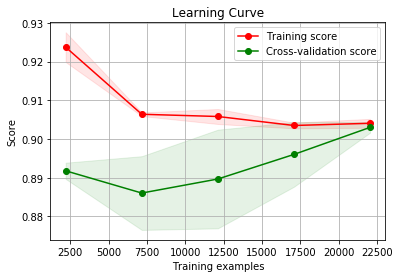

In [75]:
skplt.estimators.plot_learning_curve(model, X_train, y_train)

In [77]:
test['readmitted'] = model.predict(X_test)
test[ ['id', 'readmitted'] ].to_csv('../output/xgb_default_classifier.csv', index=False)

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
